In [1]:
import numpy as np
import random as rand
#import network_equ_xy_energy 
#import network_gen_isotropic 
import openpyxl 
import collections
import timeit
import glob
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import cm
import math
from scipy.optimize import fsolve, root
import scipy.optimize as optimize

In [2]:

title_font = {'fontname':'Arial', 'size':'15', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'13'}


In [5]:
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from matplotlib.tri import Triangulation, TriAnalyzer, UniformTriRefiner
import matplotlib as mpl
import matplotlib.pyplot as plt

# Check NN convexity with respect to C given convexity with respect to I1, I2

In [6]:
import tensorflow as tf
import tensorflow.nn as nn
import tensorflow.keras as K
import tensorflow.keras.backend as Kb
#import keras
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [57]:
fiber_diameter = 0.1
percent_volume_fraction = 0.3
#scaler_mean = np.array([0.161499,0.45089,3.18844,3.22341]) #0.161499,0.45089,3.18844,3.22341
#scaler_std = np.array([0.0879712,0.281284,0.124943,0.164506])#0.0879712,0.281284,0.124943,0.164506
scaler_mean = np.array([0.1625825,0.45157744,3.18819534,3.22309462]) 
scaler_std = np.array([0.08750812,0.28193681,0.12485259,0.16435753])
#scaler_mean = np.array([0.20201773, 0.63851932, 3.18804961, 3.22289804])
#scaler_std = np.array([0.08507515, 0.20928187, 0.12478928, 0.16425357])

model_path = './convex_tape/scaledall_100_100_100_100_1_0_0_0'
model = K.models.load_model(model_path, compile=False)
model.compile(optimizer=K.optimizers.Adam(learning_rate=0.0001))

def evalNN(I1,I2):
    #model_name = 'scaled_105_105_mix_110010_15100'
    #model_name = 'scaledall_0_0_mix_1110_00100'
    #model_name = 'scaledall_100_100_mix_1110_00100'
    #model_name = 'convex_model'    
    test_input = np.array([fiber_diameter,percent_volume_fraction,I1,I2])
    rescaled_test_input = ((test_input - scaler_mean)/scaler_std)
    rescaled_test_input  = np.reshape(rescaled_test_input,(1,4))
    pred = model.predict(rescaled_test_input)
    return pred[0] # since pred has the form of [[ 1.298255  -0.8466639]]

In [58]:
def eval_sigma_NN(lamx,lamy):
    lamz = 1./(lamx*lamy)
    I1 = lamx**2+lamy**2+lamz**2
    I2 = lamx**2 * lamy**2 + lamx**2 * lamz**2 + lamy**2 * lamz**2
    Psi1,Psi2 = evalNN(I1,I2)
    #print('NN eval Psi1=%f Psi2=%f'%(Psi1,Psi2))
    #p = 2 * Psi1 * lamz ** 2 - 2 * Psi2 * lamz ** (-2)
    #sigmax = -p + 2 * Psi1 * lamx ** 2 - 2 * Psi2 * lamx ** (-2)
    #sigmay = -p + 2 * Psi1 * lamy ** 2 - 2 * Psi2 * lamy ** (-2)
            
    p = + 2 * Psi1 * lamz ** 2 + 2*Psi2*(I1*lamz**2-lamz**4)
    sigmax = -p + 2 * Psi1 * lamx ** 2 + 2*Psi2*(I1*lamx**2-lamx**4)
    sigmay = -p + 2 * Psi1 * lamy ** 2 + 2*Psi2*(I1*lamy**2-lamy**4)
    return sigmax,sigmay

In [59]:
# Get the stress for bunch of equibiaxial deformations 
lamx_ls = np.linspace(1,1.25,11)
lamy_ls = np.linspace(1,1.25,11)
I1_vec = np.zeros((11**2))
I2_vec = np.zeros((11**2))
sigma_vec = np.zeros((11**2,2))
PK2_vec = np.zeros((11**2,2))
C_vec  = np.zeros((11**2,2))

for i in range(11):
    for j in range(11):
        lamx = lamx_ls[i]
        lamy = lamy_ls[j]
        lamz = (1./(lamx*lamy))
        I1 = lamx**2+lamy**2+lamz**2
        I2 = lamx**2 * lamy**2 + lamx**2 * lamz**2 + lamy**2 * lamz**2
        I1_vec[i*11+j] = I1
        I2_vec[i*11+j] = I2
        sigmax,sigmay=eval_sigma_NN(lamx,lamy)
        sigma_vec[i*11+j,0] =sigmax
        sigma_vec[i*11+j,1] =sigmay
        sigma = np.array([[sigmax,0],[0,sigmay]])
        F = np.array([[lamx,0],[0,lamy]])
        Finv = np.linalg.inv(F)
        PK2 = np.dot(Finv,np.dot(sigma,Finv.transpose()))
        PK2_vec[i*11+j,0] = PK2[0,0]
        PK2_vec[i*11+j,1] = PK2[1,1]
        C_vec[i*11+j,0] = lamx**2
        C_vec[i*11+j,1] = lamy**2

In [60]:
## Check convexity between any pair of biaxial deformations 
convexity_checks = np.zeros((121*121))
ct=0
neg_ct = 0
pos_ct = 0
z_ct = 0
for i in range(121):
    for j in range(0,121): 
        check = np.dot(PK2_vec[j]-PK2_vec[i],C_vec[j]-C_vec[i])
        convexity_checks[ct] = check
        if check<0:
            neg_ct+=1
        elif check>0:
            pos_ct+=1
        elif check==0:
            z_ct+=1
        ct+=1


(array([6.697e+03, 3.764e+03, 2.244e+03, 1.178e+03, 4.460e+02, 1.720e+02,
        7.000e+01, 5.000e+01, 1.800e+01, 2.000e+00]),
 array([0.        , 0.24799954, 0.49599907, 0.74399861, 0.99199815,
        1.23999769, 1.48799722, 1.73599676, 1.9839963 , 2.23199584,
        2.47999537]),
 <a list of 10 Patch objects>)

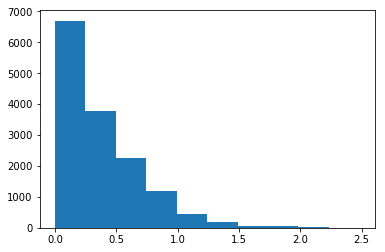

In [61]:
plt.hist(convexity_checks)

In [62]:
print(pos_ct)
print(neg_ct)
print(z_ct)

14520
0
121


In [ ]:
# check NN convexity on equibiaxial

In [63]:
lamx_ls = np.linspace(1,1.25,11)
lamy_ls = np.linspace(1,1.25,11)
I1_vec = np.zeros((11**2))
I2_vec = np.zeros((11**2))
X = np.zeros((11**2,2))
Psi1_vec = np.zeros((11**2,1))
Psi2_vec = np.zeros((11**2,1))
for i in range(11):
    for j in range(11):
        lamx = lamx_ls[i]
        lamy = lamy_ls[j]
        lamz = (1./(lamx*lamy))
        I1 = lamx**2+lamy**2+lamz**2
        I2 = lamx**2 * lamy**2 + lamx**2 * lamz**2 + lamy**2 * lamz**2
        Psi1,Psi2 = evalNN(I1,I2)
        I1_vec[i*11+j] = I1
        I2_vec[i*11+j] = I2
        Psi1_vec[i*11+j] = Psi1
        Psi2_vec[i*11+j] = Psi2


In [64]:
n_eb = 25
lam_eq_ls = np.linspace(1,1.25,n_eb)
I1_eb = np.zeros((n_eb))
I2_eb = np.zeros((n_eb))
# checking convexity only along equibiaxial
Psi1_equi = np.zeros((n_eb))
Psi2_equi = np.zeros((n_eb))
for i in range(n_eb):
    lamx = lam_eq_ls[i]
    lamy = lam_eq_ls[i]
    lamz = 1./(lamx*lamy)
    I1 = lamx**2+lamy**2+lamz**2
    I2 = lamx**2 * lamy**2 + lamx**2 * lamz**2 + lamy**2 * lamz**2
    I1_eb[i] = I1
    I2_eb[i] = I2
    Psi1,Psi2 = evalNN(I1,I2)
    Psi1_equi[i] = Psi1
    Psi2_equi[i] = Psi2

eps = 1e-5
# perturb I1
I1_eb_p1 = np.zeros((n_eb))
I1_eb_p1 = I1_eb + eps
Psi1_p1_vec = np.zeros((n_eb))
Psi1_p2_vec = np.zeros((n_eb))
Psi2_p1_vec = np.zeros((n_eb))
Psi2_p2_vec = np.zeros((n_eb))
for i in range(n_eb):
    I1p = I1_eb[i]+eps
    I1 = I1_eb[i]
    I2 = I2_eb[i]
    I2p = I2_eb[i]+eps
    Psi1_p1,Psi2_p1 = evalNN(I1p,I2)
    Psi1_p2,Psi2_p2 = evalNN(I1,I2p)
    Psi1_p1_vec[i] = Psi1_p1
    Psi1_p2_vec[i] = Psi1_p2
    Psi2_p1_vec[i] = Psi2_p1
    Psi2_p2_vec[i] = Psi2_p2

dPsidI1dI1 = (Psi1_p1_vec-Psi1_equi)/eps
dPsidI1dI2 = (Psi1_p2_vec-Psi1_equi)/eps
dPsidI2dI1 = (Psi2_p1_vec-Psi2_equi)/eps
dPsidI2dI2 = (Psi2_p2_vec-Psi2_equi)/eps

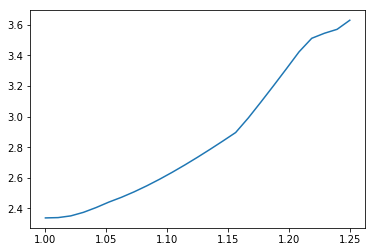

In [65]:
plt.plot(lam_eq_ls,Psi1_equi)

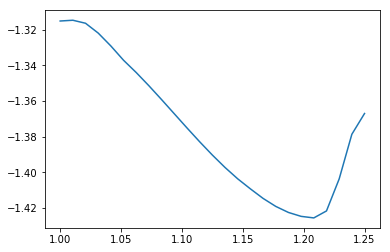

In [66]:
plt.plot(lam_eq_ls,Psi2_equi)

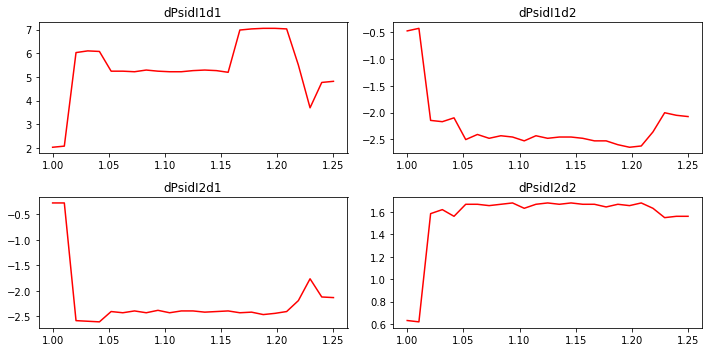

In [67]:
fig, axs = plt.subplots(2,2,figsize=(10,5))
#axs[0,0].plot(lam_eq_ls,Psi11_eb,color='black')
axs[0,0].plot(lam_eq_ls,dPsidI1dI1,color='red')
axs[0,0].set_title('dPsidI1d1')

#axs[0,1].plot(lam_eq_ls,Psi12_eb,color='black')
axs[0,1].plot(lam_eq_ls,dPsidI1dI2,color='red')
axs[0,1].set_title('dPsidI1d2')

#axs[1,0].plot(lam_eq_ls,Psi21_eb,color='black')
axs[1,0].plot(lam_eq_ls,dPsidI2dI1,color='red')
axs[1,0].set_title('dPsidI2d1')

#axs[1,1].plot(lam_eq_ls,Psi22_eb,color='black')
axs[1,1].plot(lam_eq_ls,dPsidI2dI2,color='red')
axs[1,1].set_title('dPsidI2d2')
plt.tight_layout()

In [68]:
(dPsidI2dI2*dPsidI1dI1 - dPsidI1dI2*dPsidI2dI1)

array([1.14965815, 1.16813226, 4.01286115, 4.25700364, 4.01684019,
       2.72564193, 2.89787749, 2.71057843, 2.91947799, 2.96154212,
       2.38145503, 2.88707724, 2.91521474, 2.89077207, 2.94306801,
       2.73303158, 5.51267476, 5.45469447, 5.36516609, 5.22646815,
       5.5067062 , 3.81731979, 2.19358753, 3.09569259, 3.09483994])

# Check RVE data 

We can check if the RVE data is convex even before we can try to fit it with the neural network. 
Then, as long as the NN tries to interpolate the convex function it will be convex at those points. 

In [88]:
# Load in the RVE data for just one microstructure 
# data_biaxial = pd.read_csv('biaxial_networks_optimized_dri.csv')  
data_biaxial = pd.read_csv('networks_theta_0.3_scaled_optimized_dri.csv')

In [89]:
data_biaxial

seeds  cube_length  fiber_diameter  percent_volume_fraction  \
0        250         21.7             0.1                 0.307002   
1        250         21.7             0.1                 0.307002   
2        250         21.7             0.1                 0.307002   
3        250         21.7             0.1                 0.307002   
4        250         21.7             0.1                 0.307002   
...      ...          ...             ...                      ...   
12095    400         27.0             0.1                 0.302023   
12096    400         27.0             0.1                 0.302023   
12097    400         27.0             0.1                 0.302023   
12098    400         27.0             0.1                 0.302023   
12099    400         27.0             0.1                 0.302023   

       total_fibers  inner_nodes  percent_inner_node  lambdaX  lambdaY  \
0               367          117               0.468     1.00    1.000   
1               367          117               0.468     1.00    1.025   
2               367          117               0.468     1.00    1.050   
3               367          117               0.468     1.00    1.075   
4               367          117               0.468     1.00    1.100   
...             ...          ...                 ...      ...      ...   
12095           630          230               0.575     1.25    1.150   
12096           630          230               0.575     1.25    1.175   
12097           630          230               0.575     1.25    1.200   
12098           630          230               0.575     1.25    1.225   
12099           630          230               0.575     1.25    1.250   

        lambdaZ  ...  total_psif  psif_scaled   dPsidI1   dPsidI2  \
0      1.000000  ...    0.000000     0.000000  2.650369 -1.719587   
1      0.975610  ...    0.001004     0.002132  2.658896 -1.719058   
2      0.952381  ...    0.004021     0.008539  2.683611 -1.717499   
3      0.930233  ...    0.008876     0.018848  2.723233 -1.714920   
4      0.909091  ...    0.016228     0.034463  2.776484 -1.711300   
...         ...  ...         ...          ...       ...       ...   
12095  0.695652  ...    0.287326     0.394137  2.974325 -1.124600   
12096  0.680851  ...    0.323225     0.443381  2.990988 -1.069289   
12097  0.666667  ...    0.363697     0.498899  2.995015 -0.999460   
12098  0.653061  ...    0.410419     0.562989  2.983712 -0.915470   
12099  0.640000  ...    0.465125     0.638031  2.952660 -0.819169   

       rho_unRestrict  phi_1_unRestrict  phi_2_unRestrict  rho_Restrict  \
0            8.739912          2.650369         -1.719587      5.300738   
1            8.735580          2.657993         -1.720017      5.226819   
2            8.757983          2.681457         -1.720076      5.062091   
3            8.796194          2.718312         -1.720997      4.831238   
4            8.861334          2.774149         -1.715905      4.601087   
...               ...               ...               ...           ...   
12095        7.571676          2.976541         -1.115075      2.501702   
12096        7.439426          2.992881         -1.061260      2.397209   
12097        7.224164          2.993453         -0.996543      2.286712   
12098        6.927660          2.977523         -0.919983      2.184646   
12099        6.537577          2.945972         -0.829619      2.096588   

       phi_1_Restrict  phi_2_Restrict  
0            2.650369    6.188760e-16  
1            2.625056    1.113390e-15  
2            2.559440   -8.950410e-16  
3            2.470584    5.305670e-15  
4            2.385498    8.389430e-16  
...               ...             ...  
12095        1.865222   -1.972830e-15  
12096        1.869778    1.009760e-15  
12097        1.881131    6.032730e-16  
12098        1.901325   -7.368840e-17  
12099        1.934816   -3.623420e-16  

[12100 rows x 25 columns]

In [90]:
list(data_biaxial.columns)

['seeds',
 'cube_length',
 'fiber_diameter',
 'percent_volume_fraction',
 'total_fibers',
 'inner_nodes',
 'percent_inner_node',
 'lambdaX',
 'lambdaY',
 'lambdaZ',
 'sigmaXX',
 'sigmaYY',
 'sigmaZZ',
 'I1',
 'I2',
 'total_psif',
 'psif_scaled',
 'dPsidI1',
 'dPsidI2',
 'rho_unRestrict',
 'phi_1_unRestrict',
 'phi_2_unRestrict',
 'rho_Restrict',
 'phi_1_Restrict',
 'phi_2_Restrict']

In [258]:
# for each microstructure compute the PK2 from dPsidI1 and dPsidI2 and 
# then do the convexity check 
# how to sub-select data? 
rvei=16
ind1=121*rvei
ind2=121*(rvei+1)
lamx_vec = data_biaxial['lambdaX'][ind1:ind2].to_numpy()
lamy_vec = data_biaxial['lambdaY'][ind1:ind2].to_numpy()
Psi1_vec = data_biaxial['phi_1_unRestrict'][ind1:ind2].to_numpy()
Psi2_vec = data_biaxial['phi_2_unRestrict'][ind1:ind2].to_numpy()
#Psi1_vec = data_biaxial['dPsidI1'][ind1:ind2].to_numpy()
#Psi2_vec = data_biaxial['dPsidI2'][ind1:ind2].to_numpy()
Psi_vec = data_biaxial['psif_scaled'][ind1:ind2].to_numpy()
#
sigmax_vec = data_biaxial['sigmaXX'][ind1:ind2].to_numpy()
sigmay_vec = data_biaxial['sigmaYY'][ind1:ind2].to_numpy()

In [259]:
## Check convexity between any pair of biaxial deformations 
convexity_checks = np.zeros((121*121))
convexity_checks_rve = np.zeros((121*121))
PK2_vec = np.zeros((121,2))
PK2rve_vec = np.zeros((121,2))
stress_error = np.zeros((121,1))
ct=0
neg_ct = 0
pos_ct = 0
z_ct = 0
for i in range(121):
    # generate the stress for point 'i' but based on my interpolation of Psi1 and Psi2 
    lamx_i = lamx_vec[i]
    lamy_i = lamy_vec[i]
    lamz_i = 1./(lamx_i*lamy_i)
    I1_i = lamx_i**2 + lamy_i**2 + lamz_i**2 
    I2_i = lamx_i**2*lamy_i**2 + lamy_i**2*lamz_i**2  + lamz_i**2*lamx_i**2 
    dPsidI1 = Psi1_vec[i]
    dPsidI2 = Psi2_vec[i]
    # PK2 = 2*Psi1*I + 2*Psi2*(I1*I-C) + p*Cinv 
    # from the plane stress we get 
    p = -(2*dPsidI1+2*dPsidI2*(I1_i-lamz_i**2))*lamz_i**2
    C2d_i = np.array([[lamx_i**2,0],[0,lamy_i**2]])
    C2dinv_i = np.array([[1/lamx_i**2,0],[0,1/lamy_i**2]])
    PK2_i = 2*dPsidI1*np.eye(2) + 2*dPsidI2*(I1_i*np.eye(2)-C2d_i) + p*C2dinv_i
    # does this match the stress I have in the array? 
    PK2_vec[i,0] = PK2_i[0,0]
    PK2_vec[i,1] = PK2_i[1,1]
    # the stress from the RVE simulation directly is cauchy, transform to PK2 
    F = np.array([[lamx_i,0],[0,lamy_i]])
    Finv = np.array([[1/lamx_i,0],[0,1/lamy_i]])
    sigma = np.array([[sigmax_vec[i],0],[0,sigmay_vec[i]]])
    PK2rve = np.dot(Finv,np.dot(sigma,Finv.transpose()))
    PK2rve_vec[i,0] = PK2rve[0,0]
    PK2rve_vec[i,1] = PK2rve[1,1]
    stress_error[i] = np.sqrt((PK2_i[0,0]-PK2rve[0,0])**2+(PK2_i[1,1]-PK2rve[1,1])**2)
    C_i = np.array([lamx_vec[i]**2,lamy_vec[i]**2])
    for j in range(0,121): 
        # Taylor expansion 
        # Psi_j = Psi_i + dSdC_i:(C_j - C_i)
        # Previous check was done with PK2 pulled back from sigma
        # check = Psi_vec[j]- Psi_vec[i] - 0.5*np.dot(PK2_vec[i],C_vec[j]-C_vec[i])
        # Instead, I want to do it with the PK2 built up with the Psi1 and Psi2 
        # keep the energy from the data, only thing that is calculated differently from
        # the previous check is the PK2 
        C_j = np.array([lamx_vec[j]**2,lamy_vec[j]**2])
        check = Psi_vec[j]- Psi_vec[i] - 0.5*np.dot(np.array([PK2_i[0,0],PK2_i[1,1]]),C_j-C_i)
        convexity_checks[ct] = check
        check_rve = Psi_vec[j]- Psi_vec[i] - 0.5*np.dot(np.array([PK2rve[0,0],PK2rve[1,1]]),C_j-C_i)
        convexity_checks[ct] = check
        convexity_checks_rve[ct] = check_rve
        if check<0:
            #print('not satisfied')
            #print(C_i)
            #print(C_j)
            #print(C_j-C_i)
            #print(PK2_i)
            neg_ct+=1
        elif check>0:
            #print('satisfied')
            #print(C_j-C_i)
            pos_ct+=1
        elif check==0:
            z_ct+=1
        ct+=1

(array([5.263e+03, 4.662e+03, 2.628e+03, 1.304e+03, 4.620e+02, 1.910e+02,
        8.100e+01, 3.600e+01, 1.100e+01, 3.000e+00]),
 array([-0.02743208,  0.05317706,  0.13378621,  0.21439535,  0.29500449,
         0.37561363,  0.45622278,  0.53683192,  0.61744106,  0.69805021,
         0.77865935]),
 <a list of 10 Patch objects>)

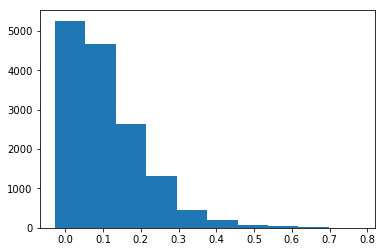

In [260]:
plt.hist(convexity_checks)

(array([4.701e+03, 4.593e+03, 2.776e+03, 1.572e+03, 6.140e+02, 2.300e+02,
        9.700e+01, 3.800e+01, 1.600e+01, 4.000e+00]),
 array([-0.02959799,  0.04788577,  0.12536953,  0.20285328,  0.28033704,
         0.3578208 ,  0.43530455,  0.51278831,  0.59027207,  0.66775583,
         0.74523958]),
 <a list of 10 Patch objects>)

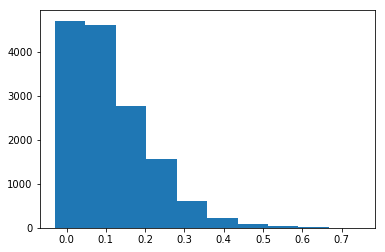

In [261]:
plt.hist(convexity_checks_rve)

In [262]:
print(pos_ct)
print(neg_ct)
print(neg_ct/(pos_ct+neg_ct)*100)

14199
321
2.2107438016528924


In [250]:
# Printing the stress and the error 
print(np.hstack([PK2_vec,PK2rve_vec,stress_error]))

[[0.         0.         0.         0.         0.        ]
 [0.07279996 0.15582363 0.01082935 0.10372192 0.08096261]
 [0.13176409 0.3037735  0.03423745 0.23269863 0.12067759]
 [0.18229201 0.45324625 0.06610574 0.38799439 0.1332556 ]
 [0.22859288 0.61092631 0.09977759 0.56100361 0.13815084]
 [0.27389626 0.78141819 0.14448052 0.73209483 0.13849631]
 [0.32060752 0.96769364 0.19120266 0.92824854 0.13528316]
 [0.37041828 1.17140244 0.23571428 1.14614947 0.13705065]
 [0.42438161 1.39308445 0.29714949 1.36698844 0.12988077]
 [0.4829604  1.63231162 0.35587482 1.59984027 0.13116834]
 [0.54605629 1.88778219 0.42470004 1.85655373 0.12530984]
 [0.15582363 0.07279996 0.09532369 0.10348795 0.067838  ]
 [0.21322947 0.21322947 0.10920995 0.1241533  0.13694752]
 [0.26232279 0.35177505 0.12994838 0.24943604 0.16732082]
 [0.30739575 0.49627605 0.17812308 0.41285563 0.15385184]
 [0.35173374 0.65220291 0.21709764 0.5877059  0.14928745]
 [0.39778468 0.82319967 0.26483567 0.76520253 0.14504864]
 [0.44727991 1

(array([ 1.,  0.,  0.,  1.,  1.,  2.,  7., 17., 47., 45.]),
 array([0.        , 0.01785734, 0.03571468, 0.05357202, 0.07142936,
        0.0892867 , 0.10714404, 0.12500139, 0.14285873, 0.16071607,
        0.17857341]),
 <a list of 10 Patch objects>)

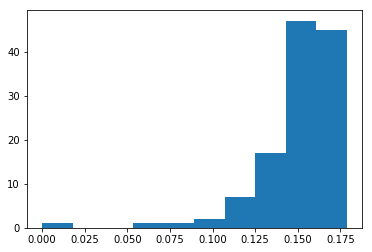

In [263]:
plt.hist(stress_error)
#plt.savefig('stress_error_optimized.png')

In [252]:
# the error is actually worsed after optimization than the original one, which is not correct 
# meaning something in the 'optimized' is not well done 
# there is one inconsistency in the energy which is that the RVE does not have plane stress, but I dont add that
# to the energy and I should. I can correct for that. That's a small error. 
# The NN should push the Psi1 and Psi2 to get convexity and that's the most important correction. 
# Different check for the convexity is the monotonicity

## Check convexity between any pair of biaxial deformations 
convexity_checks = np.zeros((121*121))
ct=0
neg_ct = 0
pos_ct = 0
z_ct = 0
for i in range(121):
    # generate the stress for point 'i' but based on my interpolation of Psi1 and Psi2 
#     lamx_i = lamx_vec[i]
#     lamy_i = lamy_vec[i]
#     lamz_i = 1./(lamx_i*lamy_i)
#     I1_i = lamx_i**2 + lamy_i**2 + lamz_i**2 
#     I2_i = lamx_i**2*lamy_i**2 + lamy_i**2*lamz_i**2  + lamz_i**2*lamx_i**2 
#     dPsidI1 = Psi1_vec[i]
#     dPsidI2 = Psi2_vec[i]
#     # PK2 = 2*Psi1*I + 2*Psi2*(I1*I-C) + p*Cinv 
#     # from the plane stress we get 
#     p = -(2*dPsidI1+2*dPsidI2*(I1_i-lamz_i**2))*lamz_i**2
#     C2d_i = np.array([[lamx_i**2,0],[0,lamy_i**2]])
#     C2dinv_i = np.array([[1/lamx_i**2,0],[0,1/lamy_i**2]])
#     PK2_i = 2*dPsidI1*np.eye(2) + 2*dPsidI2*(I1_i*np.eye(2)-C2d_i) + p*C2dinv_i
#     # does this match the stress I have in the array? 
#     PK2_vec[i,0] = PK2_i[0,0]
#     PK2_vec[i,1] = PK2_i[1,1]
    C_i = np.array([lamx_vec[i]**2,lamy_vec[i]**2])
    for j in range(0,121): 
        # Monotonicity check 
        C_j = np.array([lamx_vec[j]**2,lamy_vec[j]**2])
        check = np.dot(PK2_vec[j]-PK2_vec[i],C_j-C_i)
        convexity_checks[ct] = check
        if check<0:
            #print('not satisfied: Ci,Cj,Pk2i')
            #print(C_i)
            #print(C_j)
            #print(PK2_i)
            neg_ct+=1
        elif check>0:
            pos_ct+=1
        elif check==0:
            z_ct+=1
        ct+=1

(array([6.571e+03, 3.724e+03, 2.260e+03, 1.240e+03, 4.760e+02, 2.040e+02,
        1.000e+02, 3.800e+01, 2.200e+01, 6.000e+00]),
 array([0.        , 0.28400753, 0.56801506, 0.85202259, 1.13603012,
        1.42003765, 1.70404518, 1.98805271, 2.27206024, 2.55606778,
        2.84007531]),
 <a list of 10 Patch objects>)

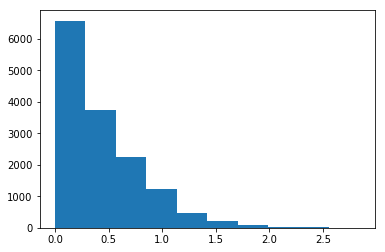

In [253]:
plt.hist(convexity_checks)

In [254]:
# let's check for all RVEs 
fraction_nonconvex_rve = np.zeros((100))
for rvei in range(100):
    ind1=121*rvei
    ind2=121*(rvei+1)
    lamx_vec = data_biaxial['lambdaX'][ind1:ind2].to_numpy()
    lamy_vec = data_biaxial['lambdaY'][ind1:ind2].to_numpy()
    Psi1_vec = data_biaxial['phi_1_unRestrict'][ind1:ind2].to_numpy()
    Psi2_vec = data_biaxial['phi_2_unRestrict'][ind1:ind2].to_numpy()
    #Psi1_vec = data_biaxial['dPsidI1'][ind1:ind2].to_numpy()
    #Psi2_vec = data_biaxial['dPsidI2'][ind1:ind2].to_numpy()
    Psi_vec = data_biaxial['psif_scaled'][ind1:ind2].to_numpy()
    #sigmax_vec = data_biaxial['sigmaXX'][ind1:ind2].to_numpy()
    #sigmay_vec = data_biaxial['sigmaYY'][ind1:ind2].to_numpy()
    convexity_checks = np.zeros((121*121))
    PK2_vec = np.zeros((121,2))
    ct=0
    neg_ct = 0
    pos_ct = 0
    z_ct = 0
    for i in range(121):
        # generate the stress for point 'i' but based on my interpolation of Psi1 and Psi2 
        lamx_i = lamx_vec[i]
        lamy_i = lamy_vec[i]
        lamz_i = 1./(lamx_i*lamy_i)
        I1_i = lamx_i**2 + lamy_i**2 + lamz_i**2 
        I2_i = lamx_i**2*lamy_i**2 + lamy_i**2*lamz_i**2  + lamz_i**2*lamx_i**2 
        dPsidI1_i = Psi1_vec[i]
        dPsidI2_i = Psi2_vec[i]
        # PK2 = 2*Psi1*I + 2*Psi2*(I1*I-C) + p*Cinv 
        # from the plane stress we get 
        p = -(2*dPsidI1_i+2*dPsidI2_i*(I1_i-lamz_i**2))*lamz_i**2
        C2d_i = np.array([[lamx_i**2,0],[0,lamy_i**2]])
        C2dinv_i = np.array([[1/lamx_i**2,0],[0,1/lamy_i**2]])
        PK2_i = 2*dPsidI1_i*np.eye(2) + 2*dPsidI2_i*(I1_i*np.eye(2)-C2d_i) + p*C2dinv_i
        # does this match the stress I have in the array? 
        PK2_vec[i,0] = PK2_i[0,0]
        PK2_vec[i,1] = PK2_i[1,1]
        C_i = np.array([lamx_vec[i]**2,lamy_vec[i]**2])
        for j in range(0,121): 
            lamx_j = lamx_vec[j]
            lamy_j = lamy_vec[j]
            lamz_j = 1./(lamx_j*lamy_j)
            I1_j = lamx_j**2 + lamy_j**2 + lamz_j**2 
            I2_j = lamx_j**2*lamy_j**2 + lamy_j**2*lamz_j**2  + lamz_j**2*lamx_j**2 
            dPsidI1_j = Psi1_vec[j]
            dPsidI2_j = Psi2_vec[j]
            # PK2 = 2*Psi1*I + 2*Psi2*(I1*I-C) + p*Cinv 
            # from the plane stress we get 
            p = -(2*dPsidI1_j+2*dPsidI2_j*(I1_j-lamz_j**2))*lamz_j**2
            C2d_j = np.array([[lamx_j**2,0],[0,lamy_j**2]])
            C2dinv_j = np.array([[1/lamx_j**2,0],[0,1/lamy_j**2]])
            PK2_j = 2*dPsidI1_j*np.eye(2) + 2*dPsidI2_j*(I1_j*np.eye(2)-C2d_j) + p*C2dinv_j
            # does this match the stress I have in the array? 
            PK2_vec[j,0] = PK2_j[0,0]
            PK2_vec[j,1] = PK2_j[1,1]
            C_j = np.array([lamx_vec[j]**2,lamy_vec[j]**2])
            # check 
            check = np.dot(PK2_vec[j]-PK2_vec[i],C_j-C_i)
            if check<0:
                #print('not satisfied: Ci,Cj,Pk2i')
                #print(C_i)
                #print(C_j)
                #print(PK2_i)
                neg_ct+=1
            elif check>0:
                pos_ct+=1
            elif check==0:
                z_ct+=1
            ct+=1
    frac = neg_ct/(neg_ct+pos_ct)*100
    fraction_nonconvex_rve[rvei] = frac
        

In [255]:
fraction_nonconvex_rve

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [273]:
# let's check for all RVEs but this time the other test
fraction_nonconvex_rve = np.zeros((100))
for rvei in range(100):
    ind1=121*rvei
    ind2=121*(rvei+1)
    lamx_vec = data_biaxial['lambdaX'][ind1:ind2].to_numpy()
    lamy_vec = data_biaxial['lambdaY'][ind1:ind2].to_numpy()
    Psi1_vec = data_biaxial['phi_1_unRestrict'][ind1:ind2].to_numpy()
    Psi2_vec = data_biaxial['phi_2_unRestrict'][ind1:ind2].to_numpy()
    #Psi1_vec = data_biaxial['dPsidI1'][ind1:ind2].to_numpy()
    #Psi2_vec = data_biaxial['dPsidI2'][ind1:ind2].to_numpy()
    Psi_vec = data_biaxial['psif_scaled'][ind1:ind2].to_numpy()
    #sigmax_vec = data_biaxial['sigmaXX'][ind1:ind2].to_numpy()
    #sigmay_vec = data_biaxial['sigmaYY'][ind1:ind2].to_numpy()
    convexity_checks = np.zeros((121*61))
    PK2_vec = np.zeros((121,2))
    ct=0
    neg_ct = 0
    pos_ct = 0
    z_ct = 0
    for i in range(121):
        # generate the stress for point 'i' but based on my interpolation of Psi1 and Psi2 
        lamx_i = lamx_vec[i]
        lamy_i = lamy_vec[i]
        lamz_i = 1./(lamx_i*lamy_i)
        I1_i = lamx_i**2 + lamy_i**2 + lamz_i**2 
        I2_i = lamx_i**2*lamy_i**2 + lamy_i**2*lamz_i**2  + lamz_i**2*lamx_i**2 
        dPsidI1_i = Psi1_vec[i]
        dPsidI2_i = Psi2_vec[i]
        # PK2 = 2*Psi1*I + 2*Psi2*(I1*I-C) + p*Cinv 
        # from the plane stress we get 
        p = -(2*dPsidI1_i+2*dPsidI2_i*(I1_i-lamz_i**2))*lamz_i**2
        #p = -(dPsidI1_i+dPsidI2_i*(I1_i-lamz_i**2))*lamz_i**2
        C2d_i = np.array([[lamx_i**2,0],[0,lamy_i**2]])
        C2dinv_i = np.array([[1/lamx_i**2,0],[0,1/lamy_i**2]])
        PK2_i = 2*dPsidI1_i*np.eye(2) + 2*dPsidI2_i*(I1_i*np.eye(2)-C2d_i) + p*C2dinv_i
        #PK2_i = dPsidI1_i*np.eye(2) + dPsidI2_i*(I1_i*np.eye(2)-C2d_i) + p*C2dinv_i
        # does this match the stress I have in the array? 
        PK2_vec[i,0] = PK2_i[0,0]
        PK2_vec[i,1] = PK2_i[1,1]
        C_i = np.array([lamx_vec[i]**2,lamy_vec[i]**2])
        for j in range(0,121): 
            lamx_j = lamx_vec[j]
            lamy_j = lamy_vec[j]
            lamz_j = 1./(lamx_j*lamy_j)
            I1_j = lamx_j**2 + lamy_j**2 + lamz_j**2 
            I2_j = lamx_j**2*lamy_j**2 + lamy_j**2*lamz_j**2  + lamz_j**2*lamx_j**2 
            dPsidI1_j = Psi1_vec[j]
            dPsidI2_j = Psi2_vec[j]
            # PK2 = 2*Psi1*I + 2*Psi2*(I1*I-C) + p*Cinv 
            # from the plane stress we get 
            p = -(2*dPsidI1_j+2*dPsidI2_j*(I1_j-lamz_j**2))*lamz_j**2
            #p = -(dPsidI1_j+dPsidI2_j*(I1_j-lamz_j**2))*lamz_j**2
            C2d_j = np.array([[lamx_j**2,0],[0,lamy_j**2]])
            C2dinv_j = np.array([[1/lamx_j**2,0],[0,1/lamy_j**2]])
            PK2_j = 2*dPsidI1_j*np.eye(2) + 2*dPsidI2_j*(I1_j*np.eye(2)-C2d_j) + p*C2dinv_j
            #PK2_j = dPsidI1_j*np.eye(2) + dPsidI2_j*(I1_j*np.eye(2)-C2d_j) + p*C2dinv_j
            # does this match the stress I have in the array? 
            PK2_vec[j,0] = PK2_j[0,0]
            PK2_vec[j,1] = PK2_j[1,1]
            C_j = np.array([lamx_vec[j]**2,lamy_vec[j]**2])
            # check 
            #check = np.dot(PK2_vec[j]-PK2_vec[i],C_j-C_i)
            check = Psi_vec[j]- Psi_vec[i] - 0.5*np.dot(np.array([PK2_i[0,0],PK2_i[1,1]]),C_j-C_i)
            if check<0:
                #print('not satisfied: Ci,Cj,Pk2i')
                #print(C_i)
                #print(C_j)
                #print(PK2_i)
                neg_ct+=1
            elif check>0:
                pos_ct+=1
            elif check==0:
                z_ct+=1
            ct+=1
    frac = neg_ct/(neg_ct+pos_ct)*100
    fraction_nonconvex_rve[rvei] = frac

In [274]:
print(fraction_nonconvex_rve.mean())
fraction_nonconvex_rve

3.8286501377410462


array([ 1.38429752,  2.87878788,  1.7768595 ,  2.45179063,  6.50137741,
        2.4862259 ,  4.22176309,  2.09366391,  2.75482094,  4.4077135 ,
        5.49586777,  3.6707989 ,  3.44352617,  3.69146006,  6.11570248,
        4.05647383,  2.2107438 ,  4.35950413,  4.57300275,  3.71900826,
        4.04269972,  3.17493113,  4.06336088,  2.44490358,  1.43250689,
        2.87190083,  0.70936639,  2.96143251,  4.20798898,  3.35399449,
        3.38842975,  7.16253444,  3.59504132, 10.51652893,  6.28787879,
        3.51928375,  6.29476584,  3.13360882,  3.37465565,  4.77961433,
        4.00137741,  2.52066116, 10.26859504,  3.42286501,  3.12672176,
        2.69283747,  2.32093664,  2.30027548,  2.10743802,  2.13498623,
        3.33333333,  2.74104683,  2.3415978 ,  6.29476584,  1.35674931,
        4.49724518,  9.64876033,  2.6446281 ,  4.44903581,  4.83471074,
        1.26721763,  1.72865014,  1.06060606,  0.68181818,  5.47520661,
        2.60330579,  3.63636364,  3.815427  ,  1.51515152,  7.68

(array([11., 22., 28., 20.,  5.,  7.,  3.,  0.,  2.,  2.]),
 array([ 0.68181818,  1.75619835,  2.83057851,  3.90495868,  4.97933884,
         6.05371901,  7.12809917,  8.20247934,  9.2768595 , 10.35123967,
        11.42561983]),
 <a list of 10 Patch objects>)

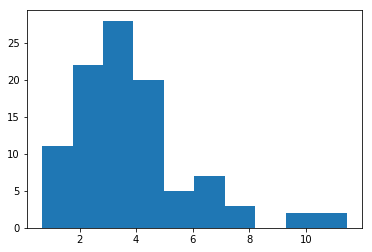

In [275]:
plt.hist(fraction_nonconvex_rve)